In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json

import os
import random
from random import random, randint, seed
import pickle
import pathlib
import warnings
import platform

import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import densenet, MobileNetV3Large, efficientnet, nasnet, MobileNetV3Small
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
print("Python- Versão: ", platform.python_version())
print("TensorFLow - Versão: ",tf.__version__)

# Checar GPUs
if not tf.test.gpu_device_name():
    warnings.warn('GPU não encontrada.')
else:
    print(f'Dispositivo GPU padrão: {tf.test.gpu_device_name()}')
    print("Número de GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))


Python- Versão:  3.8.13
TensorFLow - Versão:  2.9.1
Dispositivo GPU padrão: /device:GPU:0
Número de GPUs Disponíveis:  1


In [3]:
for dirpath, dirnames, filenames in os.walk('BreakHis400x_train_val/dataset'):
    if len(filenames)!=0:
        print(f'Existem {len(filenames)} imagens em  {dirpath}.')


Existem 1037 imagens em  BreakHis400x_train_val/dataset\train_set\benign.
Existem 1037 imagens em  BreakHis400x_train_val/dataset\train_set\malignant.
Existem 180 imagens em  BreakHis400x_train_val/dataset\validation_set\benign.
Existem 180 imagens em  BreakHis400x_train_val/dataset\validation_set\malignant.


In [4]:
train_dir = 'BreakHis400x_train_val/dataset/train_set/'
val_dir = 'BreakHis400x_train_val/dataset/validation_set/'
test_dir = 'BreCaHAD_test/dataset'

# Especificações para o treinamento da rede
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 100

In [5]:
train_datagen = ImageDataGenerator(rescale=None)
valid_datagen = ImageDataGenerator(rescale=None)
test_datagen = ImageDataGenerator(rescale=None)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

val_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

Found 2074 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [6]:
'''# Criar a arquitetura da camada densa do modelo para o Fine Tuning
inputs = Input(shape=IMG_SHAPE)

xi = tf.cast(inputs, tf.float32)
xi = tf.keras.applications.mobilenet_v3.preprocess_input(xi)

basemodel = MobileNetV3Small(include_top=False,
                        weights='imagenet',
                        input_tensor = xi,
                        input_shape=IMG_SHAPE,
                        pooling='max')

x = Dense(128, activation="relu")(basemodel.output)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)'''

'# Criar a arquitetura da camada densa do modelo para o Fine Tuning\ninputs = Input(shape=IMG_SHAPE)\n\nxi = tf.cast(inputs, tf.float32)\nxi = tf.keras.applications.mobilenet_v3.preprocess_input(xi)\n\nbasemodel = MobileNetV3Small(include_top=False,\n                        weights=\'imagenet\',\n                        input_tensor = xi,\n                        input_shape=IMG_SHAPE,\n                        pooling=\'max\')\n\nx = Dense(128, activation="relu")(basemodel.output)\nx = Dropout(0.2)(x)\nx = BatchNormalization()(x)\n\nx = Dense(64, activation="relu")(x)\nx = Dropout(0.2)(x)\nx = BatchNormalization()(x)\n\noutputs = Dense(2, activation=\'softmax\')(x)\n\nmodel = Model(inputs, outputs)'

In [7]:
# Criar a arquitetura da camada densa do modelo para o Fine Tuning
inputs = Input(shape=IMG_SHAPE)

xi = tf.cast(inputs, tf.float32)
xi = tf.keras.applications.mobilenet_v3.preprocess_input(xi)

basemodel = MobileNetV3Small(include_top=False,
                        weights='imagenet',
                        input_tensor = xi,
                        input_shape=IMG_SHAPE,
                        pooling='max')

x = Dense(256, activation="relu")(basemodel.output)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

In [8]:
#model.summary()

## Fine Tuning - Fase 1 (warm up) -> treina apenas a camada densa

In [9]:
# Congela as camadas do modelo base (as camadas de convolução não serão treinadas novamente)
for layer in basemodel.layers:
    layer.trainable = False  

In [10]:
base_learning_rate = 0.0001
opt = Adam(learning_rate=base_learning_rate)
# binary -> binary_crossentropy; categorical -> categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [11]:
# Early Stopping do trinamento
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_callbacks.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks = [early_stop, model_ckpt]

In [12]:
# Fase 1 - treina apenas com algumas épocas (40% do total)
initial_epochs = int(EPOCHS*0.4)
history = model.fit(train_data,
                    epochs=initial_epochs,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks)

Epoch 1/40
65/65 [==============================] - 29s 340ms/step - loss: 0.9458 - accuracy: 0.5501 - val_loss: 0.7294 - val_accuracy: 0.5611
Epoch 2/40
65/65 [==============================] - 21s 320ms/step - loss: 0.7565 - accuracy: 0.6504 - val_loss: 0.7693 - val_accuracy: 0.5278
Epoch 3/40
65/65 [==============================] - 20s 310ms/step - loss: 0.6510 - accuracy: 0.6885 - val_loss: 0.8173 - val_accuracy: 0.5250
Epoch 4/40
65/65 [==============================] - 21s 323ms/step - loss: 0.6160 - accuracy: 0.7155 - val_loss: 0.8093 - val_accuracy: 0.5250
Epoch 5/40
65/65 [==============================] - 21s 326ms/step - loss: 0.5854 - accuracy: 0.7343 - val_loss: 0.8329 - val_accuracy: 0.5389
Epoch 6/40
65/65 [==============================] - 21s 324ms/step - loss: 0.5450 - accuracy: 0.7512 - val_loss: 0.8063 - val_accuracy: 0.5278
Epoch 7/40
65/65 [==============================] - 21s 316ms/step - loss: 0.5531 - accuracy: 0.7430 - val_loss: 0.7811 - val_accuracy: 0.5500

## Fine Tuning - Fase 2 -> treina todo o modelo do fine tuning - descongela as camadas de convolução

In [13]:
print("Número de camadas do modelo base: ", len(basemodel.layers))

Número de camadas do modelo base:  231


In [14]:
# Descongelar as 30% camadas finais e que não seja do tipo BatchNormalization do modelo base
# Note que vpcê pode adicionar mais camadas se o modelo não for muito grande
count = 0
for layer in basemodel.layers[-int(len(basemodel.layers)*0.3):]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [15]:
# É necessário diminuir a base_learning_rate para que o modelo não tenha convergência muito rápida
# pois se trata d eum modelo grande
opt = Adam(learning_rate=base_learning_rate/10)
# binary -> binary_crossentropy; categorical -> categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [16]:
# EarlyStopping do trinamento
early_stop2 = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt2 = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_callbacks.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks2 = [early_stop2, model_ckpt2]

In [17]:
# Fase 2 - treina apenas com a quantidade de épocas que faltam (60% finais)
# Note que iniciará de initial_epoch=history.epoch[-1]
history_fine = model.fit(train_data,
                    epochs=EPOCHS,
                    initial_epoch=history.epoch[-1],
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks2)

Epoch 8/100
65/65 [==============================] - 26s 340ms/step - loss: 0.5037 - accuracy: 0.7743 - val_loss: 0.7690 - val_accuracy: 0.5500
Epoch 9/100
65/65 [==============================] - 21s 319ms/step - loss: 0.4962 - accuracy: 0.7715 - val_loss: 0.7733 - val_accuracy: 0.5472
Epoch 10/100
65/65 [==============================] - 21s 315ms/step - loss: 0.4912 - accuracy: 0.7705 - val_loss: 0.7748 - val_accuracy: 0.5528
Epoch 11/100
65/65 [==============================] - 20s 314ms/step - loss: 0.5037 - accuracy: 0.7608 - val_loss: 0.7903 - val_accuracy: 0.5444
Epoch 12/100
65/65 [==============================] - 21s 314ms/step - loss: 0.4739 - accuracy: 0.7734 - val_loss: 0.7908 - val_accuracy: 0.5444
Epoch 13/100
65/65 [==============================] - 20s 313ms/step - loss: 0.4824 - accuracy: 0.7816 - val_loss: 0.7913 - val_accuracy: 0.5444
Epoch 14/100
65/65 [==============================] - 21s 318ms/step - loss: 0.4652 - accuracy: 0.7854 - val_loss: 0.7904 - val_accu

In [18]:
# Avaliação usando os dados de testes
loss, acc = model.evaluate(test_data)
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)

5/5 [==============================] - 8s 1s/step - loss: 0.5552 - accuracy: 0.8553
Test accuracy: 0.855
Test loss: 0.555


In [19]:
model.save("Models_Save/Save_Model_MobileNetV3Small")

INFO:tensorflow:Assets written to: Models_Save/Save_Model_MobileNetV3Small\assets


INFO:tensorflow:Assets written to: Models_Save/Save_Model_MobileNetV3Small\assets


# GRADCAM

In [20]:
test_dir = 'BreCaHAD_test/dataset'
data_dir_test = pathlib.Path(test_dir)

class_names = np.array(sorted([item.name for item in data_dir_test.glob('*')]))
print(f'Types: {class_names}')

Types: ['benign' 'malignant']


In [21]:
# Carrega o modelo
model = load_model("Models_Save/Save_Model_MobileNetV3Small")

In [22]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, keras.layers.Conv2D), model.layers))[-1].name
print(last_conv_layer_name) 

Conv_1


In [23]:
def get_img_array(img_path, size):

    img = tf.keras.utils.load_img(img_path, target_size=size)
    
    array = tf.keras.utils.img_to_array(img)
    
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],[model.get_layer(last_conv_layer_name).output, model.output])
           
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    print(heatmap.shape)
    
    heatmap = tf.squeeze(heatmap)
    
    print(heatmap.shape)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    print(heatmap.shape)
    
    return heatmap.numpy()

In [24]:
# Prepare image
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=(224,224))

    preds = model.predict(img_array)
    top_pred_index = tf.argmax(preds[0])

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heat_test = heatmap.copy()

    return heatmap, class_names[top_pred_index], preds[0][top_pred_index]

In [25]:
def save_and_display_gradcam(img_path, heatmap, alpha=1, pred=None):

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    if pred == 'malignant':
        jet = cm.get_cmap("gray")
    else:
        jet = cm.get_cmap("Greens")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
     

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap)


    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)


    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)

    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return thresh

# Gerar dataset

In [26]:
def loading_json(filen='BreCaHAD_test/groundTruth/'):
    tumor_cells = {}
    annot_points = {}
    
    for root, dirs, items in os.walk(filen):
        for i, item in enumerate(items):

            f = open(filen+item)
            data = json.load(f)
            
            tumor_cells[item.split('.')[0]] = len(data['tumor'])
            
            x_y = []
            for j, points in enumerate(data['tumor']):
                values_i_j = []
                
                values_i_j.append(int(points['x']*1360))
                values_i_j.append(int(points['y']*1024))

                x_y.append(values_i_j)

            annot_points[item.split('.')[0]] = x_y

            f.close()
            
    return tumor_cells, annot_points

In [27]:
def getting_probs(filen='BreCaHAD_test/dataset/malignant/'):
    probs = []
    classes = []
    masks = []
    for root, dirs, items in os.walk(filen):
        for item in items:
            heatmap, class_, prob = generate_heatmap(filen+item)
            mask = save_and_display_gradcam(filen+item, heatmap, pred=class_)
            probs.append(round(prob*100,2))
            classes.append(class_)
            masks.append(mask)
            

    return classes, masks, probs

In [28]:
def checking_points(annot_points, lst_heatmaps):

    correct_values = []
    i = 0
    
    for k, v in annot_points.items():
        got_it_right = 0
        mask_matrix = lst_heatmaps[i]
        
        for a, b in enumerate(v):
            if mask_matrix[b[1]][b[0]] > 0:
                got_it_right += 1    
        correct_values.append(got_it_right)
        i += 1
        
    return correct_values

In [29]:
def generating_dataset():
    
    tumor_cells, annot_points = loading_json()
    lst_classes, lst_heatmaps, lst_probs = getting_probs()
    
    lst_tumors = checking_points(annot_points, lst_heatmaps)
    tumor_region = []
    accuracy = []

    tumor_cells_values = list(tumor_cells.values())
    
    for i, qtd in enumerate(lst_tumors):
        if lst_classes[i] == 'benign':
            tumor_region.append(0)
            accuracy.append(0)
            
        else:
            tumor_region.append(round((qtd/tumor_cells_values[i])*100, 2))
            
    
    dataframe = pd.DataFrame(data=[tumor_cells.keys(), tumor_cells.values(), lst_classes, lst_probs,
                                  lst_tumors, tumor_region],
                             index=['Case', 'Total Tumor Cells', 'Pred. Type', 'Probability (%)',
                                     'Tumors Found' ,'Interpret. Region Accuracy (%)']).transpose()
    
    return dataframe

In [30]:
df = generating_dataset()

1/1 [==============================] - 1s 1s/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 22ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 19ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 21ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 17ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 24ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 18ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 18ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 17ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 23ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 19ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 20ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 19ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [=========

1/1 [==============================] - 0s 18ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 20ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 18ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 20ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 19ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 19ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 19ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 20ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 21ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 20ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 23ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 19ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [==============================] - 0s 21ms/step
(7, 7, 1)
(7, 7)
(7, 7)
1/1 [=======

In [31]:
accuracy = 100*(len(df[(df['Pred. Type'] == 'malignant')].index)/len(df.index))
print("Acurácia de Classificação (%): ",round(accuracy,1))

Acurácia de Classificação (%):  85.5


In [32]:
# Interpretability

mean = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total = df[df['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind = df[df['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model = round(mean, 2)
std_deviation = round(stdd, 2)
median_model = round(median, 2)

print(f'Model Average Interpretability: {itp_model}. STD_Deviation: {std_deviation}. With Median: {median_model}')
print(f'\nMin.: {min_v} | Max.: {max_v}')

Model Average Interpretability: 27.02. STD_Deviation: 21.12. With Median: 21.75

Min.: 0.0 | Max.: 93.18


(array([30., 30., 25., 10., 11., 15.,  8.,  5.,  1.,  1.]),
 array([0.0, 9.318000000000001, 18.636000000000003, 27.954000000000004,
        37.272000000000006, 46.59, 55.90800000000001, 65.22600000000001,
        74.54400000000001, 83.86200000000001, 93.18], dtype=object),
 <BarContainer object of 10 artists>)

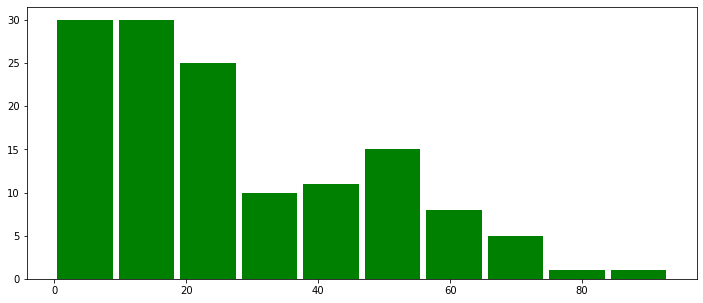

In [33]:
plt.figure(figsize=(12,5))
values = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values, bins=10, color='Green', rwidth=0.9)

### TESTE

In [78]:
def display_gradcam(img_path, heatmap, alpha=0.5, pred=None):

    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    if pred == 'malignant':
        jet = cm.get_cmap("jet")
    else:
        jet = cm.get_cmap("Greens")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
     
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap)

    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    plt.imshow(superimposed_img)

    jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_BGR2GRAY)

    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return thresh

In [79]:
df.head(20)

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
0,Case_1-01,140,malignant,83.92,5,3.57
1,Case_1-02,153,malignant,83.52,7,4.58
2,Case_1-03,135,malignant,73.92,11,8.15
3,Case_1-04,103,malignant,87.11,48,46.6
4,Case_1-05,126,malignant,84.59,102,80.95
5,Case_1-06,176,malignant,71.78,48,27.27
6,Case_1-07,196,malignant,87.99,8,4.08
7,Case_1-08,116,malignant,69.3,20,17.24
8,Case_10-01,162,benign,73.85,152,0
9,Case_10-02,139,malignant,66.01,30,21.58


In [80]:
df[df['Interpret. Region Accuracy (%)'] == df['Interpret. Region Accuracy (%)'].max()]

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
144,Case_7-09,88,malignant,80.47,82,93.18


In [81]:
case='Case_7-09' # 'Case_1-05'

In [82]:
IMG = 'BreCaHAD_test/dataset/malignant/'+case+'.png'
PATH1 = 'BreCaHAD_test/groundTruth_display/'+case+'.png'

1/1 [==============================] - 0s 31ms/step
(7, 7, 1)
(7, 7)
(7, 7)


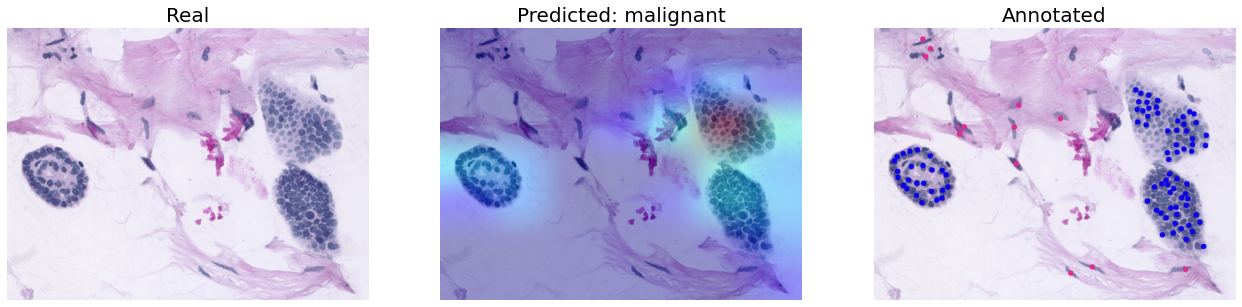

In [83]:

img = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG)
heatmap1, class_1, probs1 = generate_heatmap(IMG)

plt.figure(figsize=(22,22))
plt.subplot(1,3,1)
plt.title('Real',fontsize=20)
plt.axis(False)
plt.imshow(img_orig)
plt.subplot(1,3,2)
plt.title(f'Predicted: {class_1}', fontsize=20)
plt.axis(False)
result=display_gradcam(img_path=IMG, heatmap=heatmap1, pred=class_1)
plt.subplot(1,3,3)
plt.title('Annotated', fontsize=20)
plt.axis(False)
plt.imshow(img)

In [37]:
'''plt.figure(figsize=(10,10))

plt.imshow(result, cmap='gray')'''

"plt.figure(figsize=(10,10))\n\nplt.imshow(result, cmap='gray')"

In [38]:
'''# inverting result mask
plt.figure(figsize=(20,20))
data1 = cv.imread(PATH1)
data1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)
final = cv.bitwise_and(data1, data1, mask = result)
final = cv.cvtColor(final, cv.COLOR_RGB2GRAY)
plt.subplot(1,2,1)
plt.imshow(final, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(data1)'''

"# inverting result mask\nplt.figure(figsize=(20,20))\ndata1 = cv.imread(PATH1)\ndata1 = cv.cvtColor(data1, cv.COLOR_BGR2RGB)\nfinal = cv.bitwise_and(data1, data1, mask = result)\nfinal = cv.cvtColor(final, cv.COLOR_RGB2GRAY)\nplt.subplot(1,2,1)\nplt.imshow(final, cmap='gray')\nplt.subplot(1, 2, 2)\nplt.imshow(data1)"

In [39]:
'''plt.figure(figsize=(10,10))

kernel = np.ones((5,5),np.uint8)
mask2 = cv.threshold(final,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
mask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)
mask2 = np.uint8(mask2)
plt.imshow(mask2, cmap='gray')'''

"plt.figure(figsize=(10,10))\n\nkernel = np.ones((5,5),np.uint8)\nmask2 = cv.threshold(final,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]\nmask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, kernel)\nmask2 = np.uint8(mask2)\nplt.imshow(mask2, cmap='gray')"

In [40]:
'''plt.figure(figsize=(10,10))

data2 = data1.copy()

##########
p_edges = cv.Canny(mask2, 0, 255)

##########
rows = p_edges.shape[0]
circles = cv.HoughCircles(mask2, cv.HOUGH_GRADIENT, dp=1.1, minDist=1, param1=100, param2=15, minRadius=2, maxRadius=11)
print(circles.shape)

if circles is not None:
    # mudando o tipo de dado para int
    circles = np.uint16(np.around(circles))
    for circ in circles[0, :]:
        center = (circ[0], circ[1])

        # centro do círculo
        cv.circle(data2, center, 1, (0, 100, 100), 3)

        # círculo externo
        radius = circ[2]
        cv.circle(data2, center, radius, (0, 255, 0), 4)

plt.imshow(data2)'''

'plt.figure(figsize=(10,10))\n\ndata2 = data1.copy()\n\n##########\np_edges = cv.Canny(mask2, 0, 255)\n\n##########\nrows = p_edges.shape[0]\ncircles = cv.HoughCircles(mask2, cv.HOUGH_GRADIENT, dp=1.1, minDist=1, param1=100, param2=15, minRadius=2, maxRadius=11)\nprint(circles.shape)\n\nif circles is not None:\n    # mudando o tipo de dado para int\n    circles = np.uint16(np.around(circles))\n    for circ in circles[0, :]:\n        center = (circ[0], circ[1])\n\n        # centro do círculo\n        cv.circle(data2, center, 1, (0, 100, 100), 3)\n\n        # círculo externo\n        radius = circ[2]\n        cv.circle(data2, center, radius, (0, 255, 0), 4)\n\nplt.imshow(data2)'